# Simple orders analysis

🚀 The objective is to get an initial understanding of:
- `orders` properties
- their associated `review_scores`

In [2]:
# Import Modules 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from olist.order import Order

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
orders = Order().get_training_data()
orders

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15.0,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19.0,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26.0,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,26.0,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,12.0,0.0,delivered,1,0,5,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...
96356,9c5dedf39a927c1b2549525ed64a053c,8.0,18.0,0.0,delivered,1,0,5,1,1,72.00,13.08
96357,63943bddc261676b46f01ca7ac2f7bd8,22.0,23.0,0.0,delivered,0,0,4,1,1,174.90,20.10
96358,83c1379a015df1e13d02aae0204711ab,24.0,30.0,0.0,delivered,1,0,5,1,1,205.99,65.02
96359,11c177c8e97725db2631073c19f07b62,17.0,37.0,0.0,delivered,0,0,2,2,1,359.98,81.18


In [5]:
orders.shape

(96353, 12)

## 1 - Inspect features

👉 Summary statistics of each column of the order dataset are as below (`wait_time` is then particularly focused on)

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96353 entries, 0 to 96360
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            96353 non-null  object 
 1   wait_time           96353 non-null  float64
 2   expected_wait_time  96353 non-null  float64
 3   delay_vs_expected   96353 non-null  float64
 4   order_status        96353 non-null  object 
 5   dim_is_five_star    96353 non-null  int64  
 6   dim_is_one_star     96353 non-null  int64  
 7   review_score        96353 non-null  int64  
 8   number_of_products  96353 non-null  int64  
 9   number_of_sellers   96353 non-null  int64  
 10  price               96353 non-null  float64
 11  freight_value       96353 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


In [7]:
filtered = orders.filter(items=['wait_time','expected_wait_time','delay_vs_expected','dim_is_five_star','dim_is_one_star',\
                               'review_score','number_of_products','number_of_sellers','price','freight_value'])

📈 Histograms are plotted to get a sense of the distribution of each numerical feature.

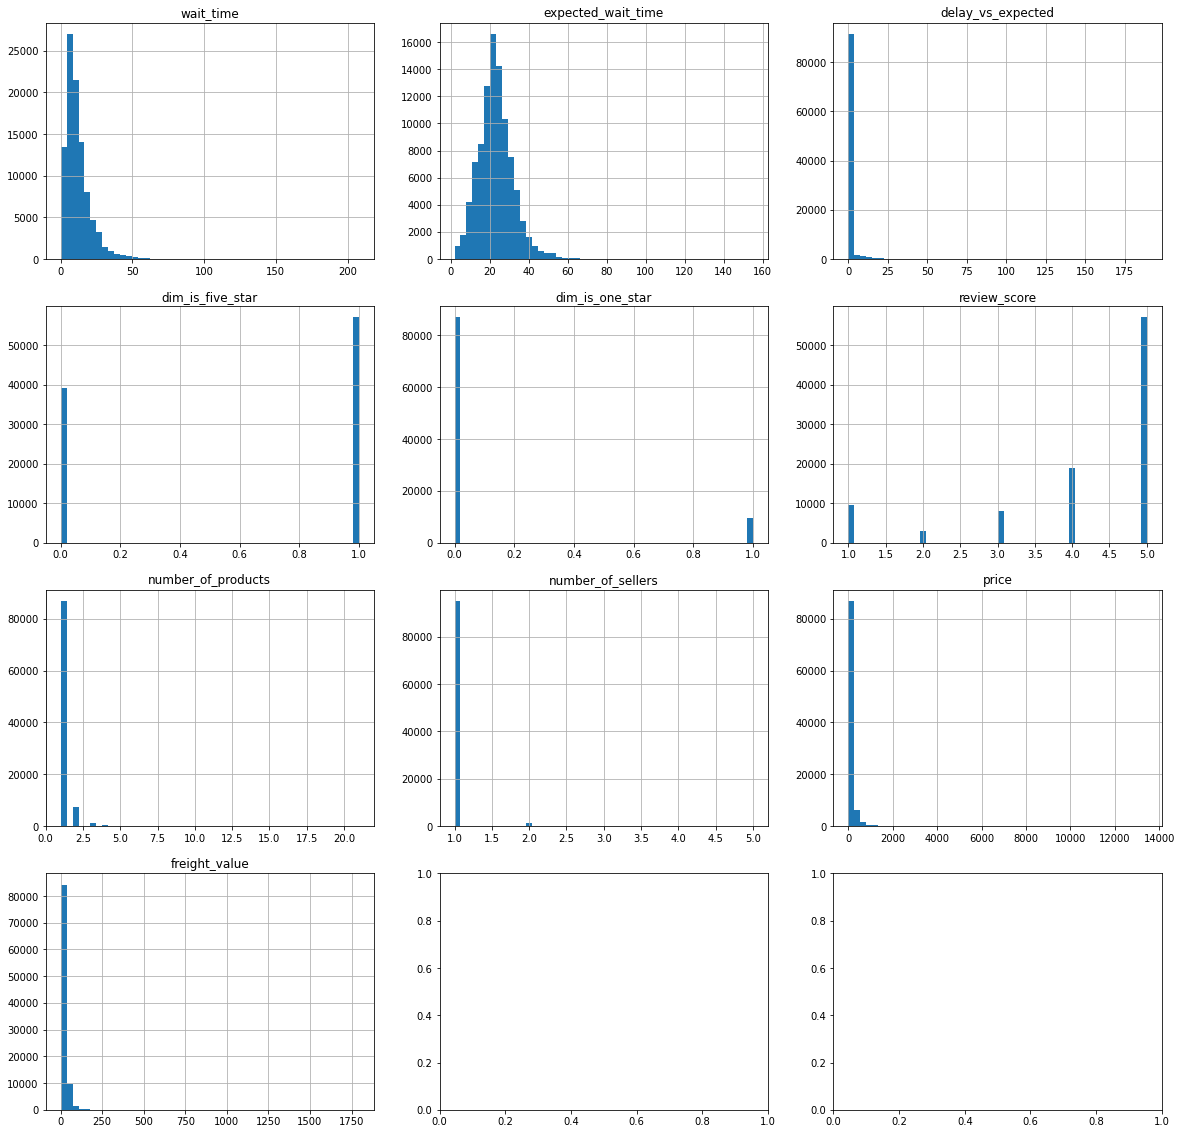

In [63]:
fig, axs = plt.subplots(4,3,figsize=(20,20))
axs = axs.flat

for index, items in enumerate(filtered.columns):
    
    orders[items].hist(ax=axs[index],bins=50)
    axs[index].set_title(items)


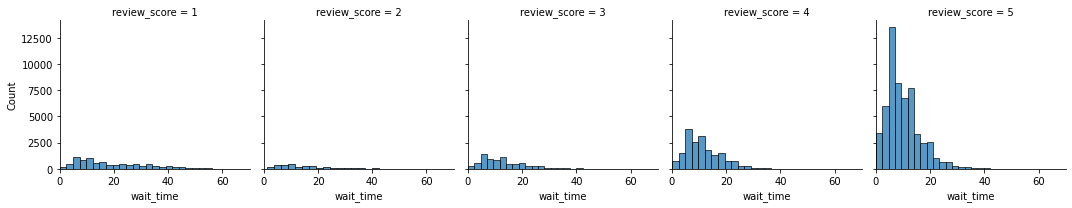

In [31]:
g = sns.FacetGrid(orders,col='review_score', xlim=(0,70))
g.map_dataframe(sns.histplot, x="wait_time",bins=80)

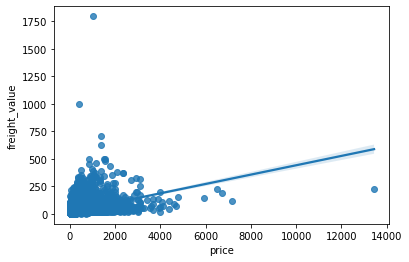

In [12]:
sns.regplot(x=orders['price'],y=orders['freight_value']);

❓The various correlations between features are inspected to confirm which feature seems to the most correlated with review_score

▸ Details * `DataFrame.corr()` is used combined with `sns.heatmap()` and `cmap='coolwarm'` * The absolute values of the correlation coefficients of `review_score` vs. each feature is looked into, * the higher the coefficient, the more one given feature is correlated (positively or negatively) with the `review_score`

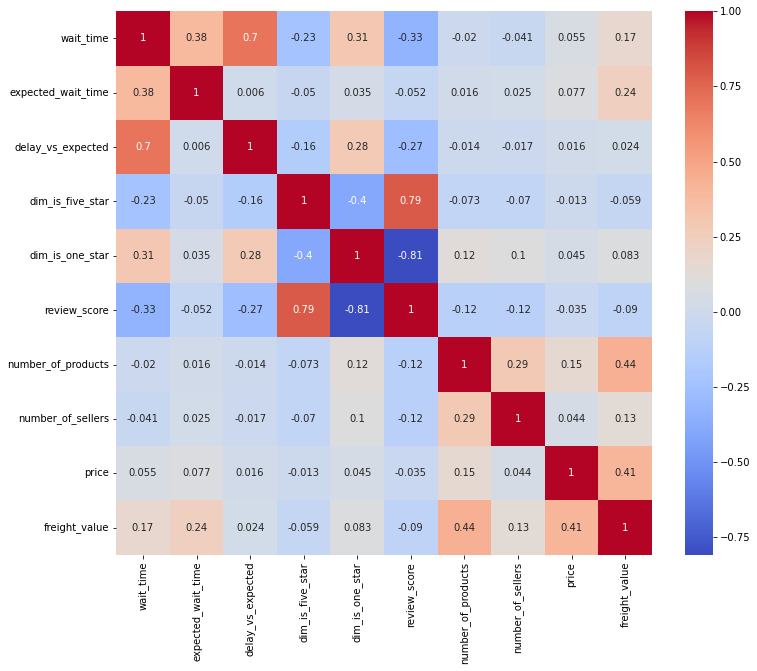

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(orders.corr(), cmap='coolwarm', annot=True);

* 😏 Observations:
    * Other than `review_score` is 100% correlated to itself 
    * and strongly correlated to `dim_is_one_star` and `dim_is_five_star`...
* ⚠️ The two next highest correlation coefficients with respect to the `review_score` will be :
    * `wait_time` : - 34 %
    * `delay_vs_expected` : 27 %

## 2 - Simple regression of `review_score` against delivery duration

👉 So, it seems that `review_score` is mostly correlated with `wait_time` (= - 34%) and `delay_vs_expected` (27%).

🎨 These correlations  are investigated and shown with `seaborn`

### 2.1 Plots
❓ In one figure, 2 subplots are created, that regress `review_score` on `wait_time` and `delay_vs_expected` respectively.

<u>Detail</u>:

- Dataframe are reduced to a random sub-`sample of 10,000 rows` for speed purposes
- `DataFrame.sample()` is used with a fixed `random_state` to avoid changing the sample at each execution if needed
- `sns.regplot()` is used to plot the `regression lines`
- Some `y_jitter` parameters are added to better visualize the scatterplot density
- `xlim` and `ylim` are set to hide outliers

In [8]:
data_sample = orders.sample(n=10000,random_state=1)

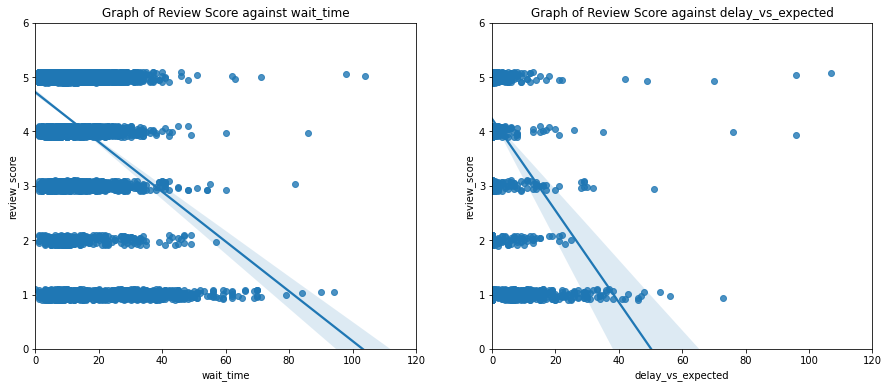

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
wait_time = sns.regplot(x='wait_time',y='review_score',data=data_sample, y_jitter=0.1, ax=ax[0])
wait_time.set_xlim(0,120)
wait_time.set_ylim(0,6)
wait_time.set_title("Graph of Review Score against wait_time")

delay_vs_exp = sns.regplot(x='delay_vs_expected',y='review_score',data=data_sample, y_jitter=0.1, ax=ax[1])
delay_vs_exp.set_xlim(0,120)
delay_vs_exp.set_ylim(0,6);
delay_vs_exp.set_title("Graph of Review Score against delay_vs_expected");

👉 `regplot` tried to perform a `Linear Regression` of the `review_score` vs. `wait_time` and `delay_vs_exp` <br/> 

👉 It doesn't look interpretable as we have only 5  different review scores which can be interpreted as a categorical variable with five different possible values (for example: "very bad", "bad", "average", "good" and "very good") that we are trying to regress against two continuous values that are `wait_time` and `delay_vs_exp`.

👀 However, based on the regression lines, we can see a very intuitive pattern: the longer the waiting time and/or the delay, the lower the review score - Well, not surprising. But how fast does the review score decrease ?


### 2.2 Interpretation

❓The  `slope` of each curve are estimated visually and it indicates how rate of score drops when the waiting time increases

- `Slope wait_time ≈ -0.05` : "For each additional day waiting for an order to be delivered, the review score on average is reduced by 0.05"
- `Slope delay ≈ -0.1` : "For each additional day waiting for an order to be delivered _after the ETA_, the review score on average is reduced by 0.1"

### 2.3 Inferential analysis

Even if we had used all 100,000 orders for these regplots, these orders represent 16 months of data after all...

⚠️⚠️⚠️ **How certain** are we that these coefficients are **statistically significant**? ⚠️⚠️⚠️

⚡️ <u> Questions about the statistical significance of these coefficients: </u>

* Are these coefficients able to generalize well to future orders (all else being equal) ? (*Ideal answer: Yes*) 
* Are we sure that these coefficients do not simply capture random fluctuations due to the limited observation period ? (*Ideal answer: No*) 

🧐 We need to estimate the **`confidence interval`** around the mean value for these two slopes  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[95% interval]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[95% interval]} $$

⭐️ Fortunately, `Seaborn` already computes this 95% confidence interval for us with a shaded blue cone around the regression line!

❓Use `Seaborn` `regplot` to visualize the two confidence intervals:
- The `size of your sample dataset` is changed: 
    - Notice how the slope may change as the sample size becomes smaller. 
    - What about the confidence interval?
- The `size of the confidence interval` is changed by playing with the regplot parameter called `ci` (95% by default)

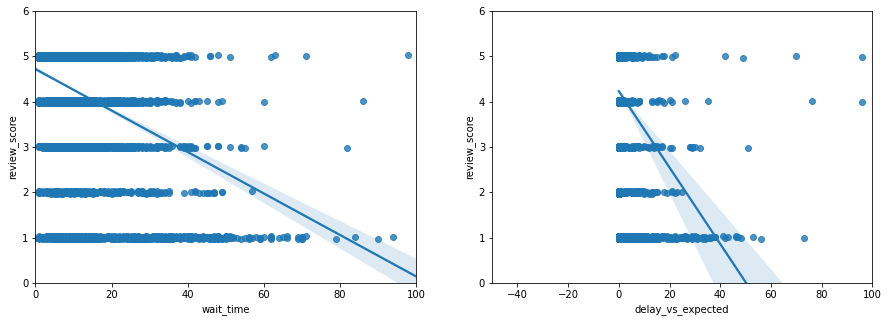

In [21]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
a = sns.regplot(x = "wait_time", y = "review_score", data = data_sample, y_jitter = 0.03, ci = 95)
a.set(xlim = (0,100))
a.set(ylim = (0, 6))

plt.subplot(1,2,2)
b = sns.regplot(x = "delay_vs_expected", y = "review_score", data = data_sample, y_jitter = 0.03, ci = 95)
b.set(xlim = (-50, 100))
b.set(ylim = (0, 6));

🔎 Interpretation:

* **Null Hypothesis** $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    - 👉 We are `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the delivery time is almost zero" is lower than 5%
    - 👉 We can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

🔥 Our findings are said to be **statistically significant**. 

⚠️ However, **correlation does NOT imply causality**. 

- It can be inherently slower to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, not matter how long their delivery time is. 

👉 Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 

